In [3]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [4]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path="checkpoint.pt"):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

In [5]:
def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['batch_idx']


In [6]:
from torch.utils.data import DataLoader, Dataset
import torch

data = torch.load(
    "/content/drive/MyDrive/sentiment_analysis/dataset/tokenized_with_labels.pt",
    weights_only=False
)



In [7]:
# build a map from original → contiguous
# label_map = {lab: i for i, lab in enumerate(sorted(unique_labels.tolist()))}
label_map = {0: 0, 1: 1, 3: 2}

# Apply it to your dataset
for item in data:
    item["labels"] = torch.tensor(label_map[item["labels"].item()], dtype=torch.long)

# Now the max label is 2, so
output_dim = len(label_map)  # = 3

In [8]:

# 2. Basic checks
print("Length of dataset:", len(data))
print("Type of first item:", type(data[0]))

# 3. Print the first item (sample)
print("First item:", data[0])

Length of dataset: 31726
Type of first item: <class 'dict'>
First item: {'input_ids': tensor([     2,   4384,   4285,   9545,     12,   3496,   1134, 109832,    477,
         26697, 134087,   7425,   2700,   4384,     31,   8351,     37,   2863,
          6511,  38637,   1883,   4285,   1640,   3496,   1134, 109832,     15,
         22186,   6169,    494,  22186,      3,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,   

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch

# Load tokenized data
# tokenized_dataset = torch.load("/content/drive/MyDrive/sentiment_analysis/dataset/tokenized_by_indicbert_data_combined.pt")
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data  # list of dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'input_ids': item['input_ids'],
            'attention_mask': item['attention_mask'],
            'label': item['labels']
        }


dataset = MyDataset(data)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
from torch.utils.data import random_split

# 80% training, 20% validation
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [18]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [19]:
def evaluate(model, val_dataloader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(val_dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class GRUSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout, pad_idx):
        super(GRUSentimentClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # input_ids: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(input_ids))  # [batch_size, seq_len, embedding_dim]

        # GRU ignores padding using pack_padded_sequence (optional for better performance)
        packed_output, hidden = self.gru(embedded)  # hidden: [n_layers * num_directions, batch_size, hidden_dim]

        if self.gru.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        output = self.fc(self.dropout(hidden))  # [batch_size, output_dim]
        return output


In [8]:
vocab_size = 200000              # For BERT/IndicBERT vocab (if using tokenizer vocab)
embedding_dim = 128             # Smaller if not using pretrained embeddings
hidden_dim = 256
output_dim = 3                  # e.g., for  sentiment classes
n_layers = 3
bidirectional = True
dropout = 0.3
pad_idx = 0                     # Usually the token ID of [PAD]
num_epochs=20


In [5]:
import os

checkpoint_dir = "/content/drive/MyDrive/sentiment_analysis/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "gru_checkpoint_1.pt")


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GRUSentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,
                               n_layers, bidirectional, dropout, pad_idx)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


import time
import numpy as np

best_valid_accuracy = 0.0
train_losses = []
train_accuracies = []
early_stopping = EarlyStopping(patience=3, delta=0.01)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    #  Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss : {avg_train_loss:.4f} | Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   Loss : {val_loss:.4f} | Accuracy: {val_accuracy:.2f}%")

    # Early Stopping Check
    early_stopping(val_loss)

    if val_loss <= early_stopping.best_loss:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  Validation loss improved. Model saved to {checkpoint_path}")

    if early_stopping.early_stop:
        print("\n Early stopping triggered.")
        break


Epoch 1/20
  Train Loss : 0.9896 | Accuracy: 50.49%
  Val   Loss : 0.8720 | Accuracy: 59.63%
  Validation loss improved. Model saved to /content/drive/MyDrive/sentiment_analysis/checkpoints/gru_checkpoint_1.pt

Epoch 2/20
  Train Loss : 0.8546 | Accuracy: 61.30%
  Val   Loss : 0.8193 | Accuracy: 63.99%
  Validation loss improved. Model saved to /content/drive/MyDrive/sentiment_analysis/checkpoints/gru_checkpoint_1.pt

Epoch 3/20
  Train Loss : 0.7885 | Accuracy: 64.95%
  Val   Loss : 0.7524 | Accuracy: 67.40%
  Validation loss improved. Model saved to /content/drive/MyDrive/sentiment_analysis/checkpoints/gru_checkpoint_1.pt

Epoch 4/20
  Train Loss : 0.7377 | Accuracy: 68.19%
  Val   Loss : 0.7526 | Accuracy: 66.94%

Epoch 5/20
  Train Loss : 0.6938 | Accuracy: 70.65%
  Val   Loss : 0.7630 | Accuracy: 68.26%

Epoch 6/20
  Train Loss : 0.6534 | Accuracy: 72.57%
  Val   Loss : 0.7691 | Accuracy: 69.41%

 Early stopping triggered.


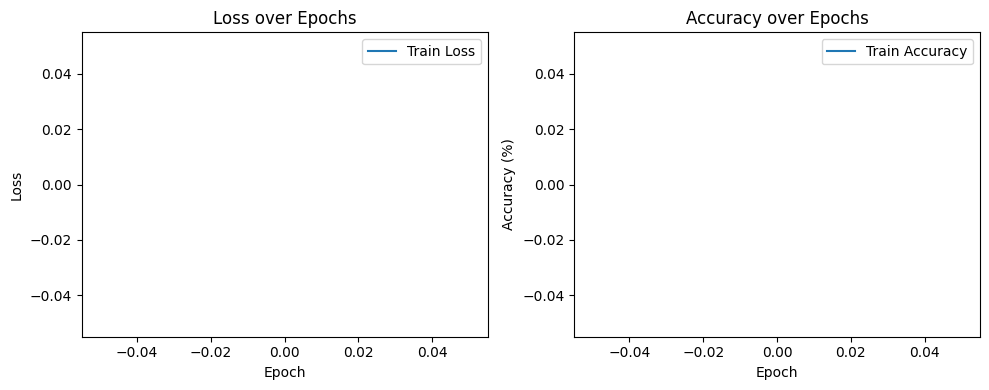

In [25]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:

model = GRUSentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim,
                               n_layers, bidirectional, dropout, pad_idx)
# model.load_state_dict(torch.load(checkpoint_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
model.to(device)
model.eval()

GRUSentimentClassifier(
  (embedding): Embedding(200000, 128, padding_idx=0)
  (gru): GRU(128, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

def preprocess_text(text, tokenizer, max_len=128):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded['input_ids'], encoded['attention_mask']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

In [14]:
def predict_sentiment(text, model, tokenizer, device, label_map=None, max_len=128):
    # Tokenize and prepare input
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Model inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)  # logits
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)

    predicted_class = predicted_class.item()
    confidence = confidence.item()

    if label_map:
        predicted_label = label_map[predicted_class]
    else:
        predicted_label = predicted_class

    return predicted_label, confidence


In [15]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
text = "मुझे यह फिल्म बहुत पसंद आई।"

prediction, confidence = predict_sentiment(text, model, tokenizer, device, label_map)
print(f"Predicted: {prediction} (Confidence: {confidence:.2f})")


Predicted: positive (Confidence: 0.95)
